# The Tully-Fisher relation for disk galaxies

The Tully-Fisher (TF) relation shows that for late type galaxies (disk galaxies), the luminosity is proportional to the maximum rotational velocity of the system [Tully & Fisher 1977]().

$$L \propto v_{max}^\gamma$$

As the velocity is almost entirely a result of the dark matter component of the total mass of the galaxy, this implies that for late type galaxies, the $M_{tot}/L$ relation is pretty much constant. The TF relation with $\gamma = 4$ has proven to be a remarkable good fit for most late type galaxies, and this also holds for the disk galaxies of TNG-100.

In [1]:
import illustris_python as il
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

def circ_velocities(df, mass_key, radius_key): #dynamical velocities
    v2 = df[mass_key]/(df[radius_key])*G
    df["CircVel"]=v2**(1/2)
    return df

def dynamical_mass(df, velocity_key, radius_key):
    mass = df[velocity_key]**2*df[radius_key]/G
    df["dyn_mass"] = mass
    return df

def power_law_log (C, a, xmin, xmax):
    y = np.logspace(xmin, xmax)
    x = a*np.log10(y) + C
    return 10**x, y

G = 4.3*10**(-6) #kpc*M^-1*(km/s)^2
h_tng = 0.6774 #Planck 2015
h_sami = 0.7000 # WMAP9

data = pd.read_pickle("../data/tng100-1/cutdata/Subhalo_Centrals_minE9_SM_lateType_Gas.pkl")
sami = pd.read_csv("../data/SAMI/lates_vrot.csv")

#converting to the same cosmology
data["SubhaloHalfmassRadStellar"] = data["SubhaloHalfmassRadStellar"]/h_tng #unit conversion
data["SubhaloVmaxRad"] = data["SubhaloVmaxRad"]/h_tng #unit conversion
sami["r_e_circ"] = sami["r_e_circ"]*h_sami/h_tng
sami["mstar"] = sami["mstar"]*h_sami**2/h_tng**2


data["SubhaloHalfmassRadStellar_2D"] = (data["SubhaloHalfmassRadStellar"])*(3/4) #from 3d to 2d projection
data = circ_velocities(data, "SubhaloMassInHalfRad", "SubhaloHalfmassRadStellar") #calculating circular velocity at R = effective radius

#dropping SAMI galaxies from Dilyar data with a large difference in mass from GAMA data
sami["mass_diff"] = sami["mstar_log"] - sami["MSAMI_log"]
index_names = sami[abs(sami["mass_diff"]) > 0.1].index
sami = sami.drop(index_names)

sami = dynamical_mass(sami, "V_rot", "r_e")

#Log-valued dataframes for plotting
data_log = il.formatplot.log_formater(data)
sami_log = il.formatplot.log_formater(sami)

The stellar mass within the half-light radius is plotted as a function of the maximum velocity. The power law with $\gamma = 4$ ish shown for comparison. The relation holds well for galaxies with mass between $10^9$ and $10^{11}$.

The rotational velocity at the half mass radius is also calculated. It can be seen that this value has a lot more scatter, probably due to the scatter in size for a given stellar mass in the early type galaxies.

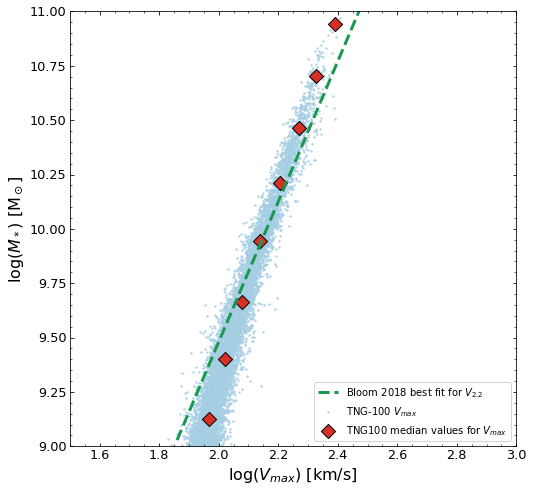

In [2]:
fig1, ax1 = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))

data_log.plot.scatter(x="SubhaloVmax", y="SubhaloMassStellar",s=2, label = r"TNG-100 $V_{max}$", alpha=0.8, color="#a6cee3", ax = ax1)

#Bloom 2018
B2018x, B2018y = power_law_log(C=-0.93, a=0.31, xmin = 9, xmax = 11.5)
B2018y = B2018y*h_sami**2/h_tng**2 #converting to same cosmology
ax1.plot(np.log10(B2018x), np.log10(B2018y), '--', linewidth = 3, label = r"Bloom 2018 best fit for $V_{2.2}$", c= "#1a9850")

#median values
mTNG_x, mTNG_y = il.stats.median_values_log_y(data, "tng", "SubhaloVmax", "SubhaloMassStellar")
ax1.scatter(np.log10(mTNG_x), np.log10(mTNG_y), marker='D', s=100, color="#d73027", edgecolors = "black", label = r"TNG100 median values for $V_{max}$")

il.formatplot.Vmax_SM(ax = ax1, x0=(1.5), x1=(3.0), y1=11)
plt.savefig("../fig/results_tully_fisher.png", dpi=300)

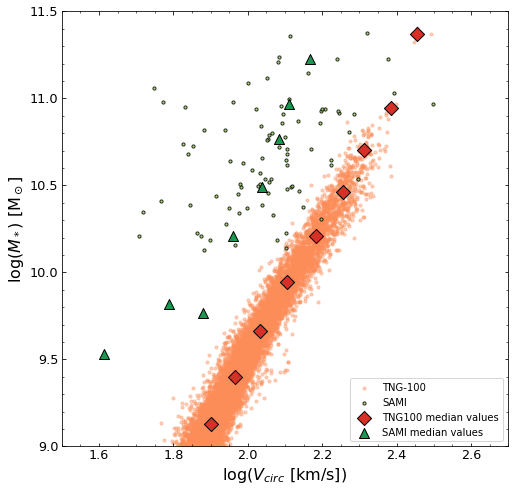

In [3]:
fig2, ax2 = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))

data_log.plot.scatter(x="CircVel", y="SubhaloMassStellar",s=10, label = "TNG-100", alpha=0.4, color="#fc8d59", ax = ax2)
#sami = circ_velocities(sami, "mstar_half", "r_e_circ")
sami_log.plot.scatter(x="V_rot", y="mstar",s=10, label = "SAMI", alpha=0.8, color="#91cf60", ax = ax2, edgecolors = "black")

#median values
mTNG_x, mTNG_y = il.stats.median_values_log_y(data, "tng", "CircVel", "SubhaloMassStellar")
mS_x, mS_y = il.stats.median_values_log_y(sami, "sami", "V_rot", "mstar")
ax2.scatter(np.log10(mTNG_x), np.log10(mTNG_y), marker='D', s=100, color="#d73027", edgecolors = "black", label = "TNG100 median values")
ax2.scatter(np.log10(mS_x), np.log10(mS_y), marker='^', s=100, color="#1a9850", edgecolors = "black", label = "SAMI median values")
il.formatplot.Vmax_SM(ax=ax2, x1 = 2.7)
plt.xlabel(r'log($V_{circ}$ [km/s])')
plt.savefig("../fig/TFR/circ_vel.png", dpi=300)

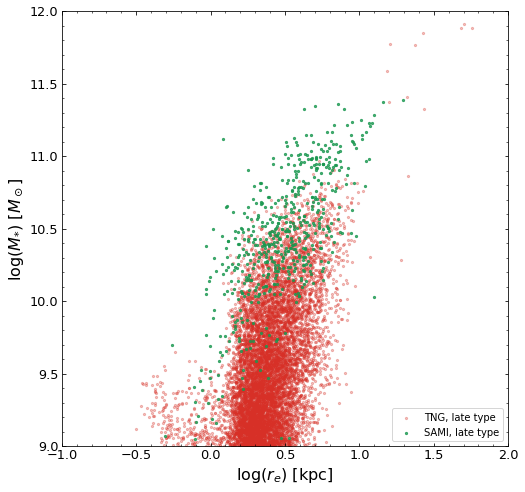

In [4]:
fig3, ax3 = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
data_log["Vmax_re"] = data["SubhaloVmaxRad"]/data["SubhaloHalfmassRadStellar"]
#data_log.plot.scatter(x = "SubhaloMassStellar", y = "CircVel", s=5, label = "V_circ at r_e", alpha=0.8, color="grey", ax = ax3)
data_log.plot.scatter(x ="SubhaloHalfmassRadStellar_2D" , y = "SubhaloMassStellar", s=5, label = "TNG, late type", alpha=0.3, color="#d73027", ax = ax3)
sami_log.plot.scatter(x ="r_e_circ" , y = "mstar", s=5, label = "SAMI, late type", alpha=0.8, color="#1a9850", ax = ax3)
il.formatplot.R_SM(ax = ax3)

In [5]:
fig4, ax4 = plt.subplots(nrows = 1, ncols = 1, figsize = (8,8))
data_log.plot.scatter(x ="SubhaloMassInHalfRad" , y = "SubhaloMassStellar", s=5, label = "TNG, late type", alpha=0.3, color="#d73027", ax = ax4)
sami_log.plot.scatter(x ="dyn_mass" , y = "mstar", s=5, label = "SAMI, late type", alpha=0.8, color="#1a9850", ax = ax4)
il.formatplot.HM_SM(title = "Dynamical mass", ax = ax4, x0 = 8)
ax4.set_xlabel(r'log($M_{total, re}$ [$ M_\odot $])')




TypeError: HM_SM() got an unexpected keyword argument 'title'